In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

Reading of data from Google Drive

In [ ]:
path = '/content/drive/MyDrive/H516/data7l.csv'

In [ ]:
data= spark.read.csv(path, header=True, inferSchema=True)

In [ ]:
data.show(10)

+---------+-------+--------+--------------+--------------+---------+----------+----------+------------+------------+--------------------+------------------+--------------+---------+-----+----------+-------+-----------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-------+--------+--------+--------+-------+-------+----------+-------+-------+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|       ID| Source|Severity|    Start_Time|      End_Time|Start_Lat| Start_Lng|   End_Lat|     End_Lng|Distance(mi)|         Description|            Street|          City|   County|State|   Zipcode|Country|   Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|   Bump|Crossing|Give

Dropping the unnecessary columns

In [ ]:
columns_to_drop = ['ID', 'Country', 'Source','Timezone','Airport_Code', 'End_Lat', 'End_Lng',  'Traffic_Calming', 'Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']
data = data.drop(*columns_to_drop)

In [ ]:
data.show(10)

+--------+--------------+--------------+---------+----------+------------+--------------------+------------------+--------------+---------+-----+----------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-------+--------+--------+--------+-------+-------+----------+-------+-------+
|Severity|    Start_Time|      End_Time|Start_Lat| Start_Lng|Distance(mi)|         Description|            Street|          City|   County|State|   Zipcode|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|   Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|   Stop|
+--------+--------------+--------------+---------+----------+------------+--------------------+------------------+--------------+---------+-----+----------+-----------------+--------------+-------------+---

Importing required Libraries

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import classification_report
import pandas as pd
from pyspark.sql.functions import col
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import roc_curve, auc as sklearn_auc
import numpy as np
from sklearn.metrics import roc_curve, auc
from pyspark.sql.functions import col
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import when
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Replacing Null values with Mean values

In [ ]:

# List of columns to replace null values with the mean
columns_to_fillna = ["Start_Lat", "Start_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Wind_Speed(mph)"]

# Replace null values with the mean for the specified columns
for column in columns_to_fillna:
    mean_value = data.select(col(column)).agg({column: 'mean'}).collect()[0][0]
    data = data.na.fill({column: mean_value})


code to replace null values with 0

In [ ]:
#from pyspark.sql.functions import when

# Assuming 'data' is your PySpark DataFrame
#data = data.fillna(0)

# Alternatively, you can use the 'when' function to replace specific columns with null values
#columns_with_nulls = ["Start_Lat", "Start_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Wind_Speed(mph)"]

#for col in columns_with_nulls:
#    data = data.withColumn(col, when(data[col].isNull(), 0).otherwise(data[col]))


Feature Engineering

In [ ]:
feature_columns = ["Start_Lat", "Start_Lng", "Temperature(F)", "Humidity(%)", "Pressure(in)", "Wind_Speed(mph)"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)


Splitting of data into Training and Testing sets

In [ ]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

**Random Forest Classifier Model**

In [ ]:
classifier = RandomForestClassifier(labelCol="Severity", featuresCol="features")
pipeline = Pipeline(stages=[classifier])
model = pipeline.fit(train_data)


In [ ]:

predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="Severity", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

# Convert predictions and labels to Pandas DataFrame for sklearn
predictions_pd = predictions.select("Severity", "prediction").toPandas()

# Get unique labels from the "Severity" column in the test data
labels = [str(label) for label in predictions.select("Severity").distinct().rdd.flatMap(lambda x: x).collect()]

# Extract labels and predictions as NumPy arrays
true_labels = predictions_pd["Severity"].values
predicted_labels = predictions_pd["prediction"].values

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in labels], zero_division=1)
print("Classification Report for Random Forest:")
print(report)

Accuracy: 0.7394386733457323
Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       0.79      0.18      0.30      4927
           3       0.75      0.98      0.85    111538
           4       0.55      0.19      0.28     22818
           2       1.00      0.00      0.00     15030

    accuracy                           0.74    154313
   macro avg       0.77      0.34      0.36    154313
weighted avg       0.75      0.74      0.66    154313



**Decision Tree Classifier Model**

In [ ]:

# Create a DecisionTreeClassifier
classifier = DecisionTreeClassifier(labelCol="Severity", featuresCol="features", maxDepth=5)

# Create a pipeline
pipeline = Pipeline(stages=[classifier])

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

# Convert predictions and labels to Pandas DataFrame for sklearn
predictions_pd = predictions.select("Severity", "prediction").toPandas()

# Extract labels and predictions as NumPy arrays
true_labels = predictions_pd["Severity"].values
predicted_labels = predictions_pd["prediction"].values

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in labels])
print("Classification Report for Decision Tree:")
print(report)


Accuracy: 0.7400478248754155
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           1       0.67      0.25      0.36      4927
           3       0.75      0.97      0.85    111538
           4       0.54      0.19      0.28     22818
           2       0.56      0.02      0.05     15030

    accuracy                           0.74    154313
   macro avg       0.63      0.36      0.38    154313
weighted avg       0.70      0.74      0.67    154313



**Linear Regression Model** which is not using because of high RMSE.

In [ ]:

feature_columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Wind_Speed(mph)"]
target_column = "Severity"

# Vector Assembler to assemble features into a single column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="my_features")

# Linear Regression model
linear_regression = LinearRegression(featuresCol="my_features", labelCol=target_column)

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, linear_regression])

# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.682512243310608


**Logistic Regression Model**

In [ ]:

# Define the logistic regression model
lr = LogisticRegression(labelCol="Severity", featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Create a pipeline with the logistic regression model
pipeline_lr = Pipeline(stages=[lr])

# Train the logistic regression model
model_lr = pipeline_lr.fit(train_data)

# Make predictions on the test data
predictions_lr = model_lr.transform(test_data)

# Evaluate the model using MulticlassClassificationEvaluator
evaluator_lr = MulticlassClassificationEvaluator(labelCol="Severity", metricName="accuracy")
accuracy_lr = evaluator_lr.evaluate(predictions_lr)

print(f"Accuracy: {accuracy_lr}")

# Convert predictions and labels to Pandas DataFrame for sklearn
predictions_pd = predictions_lr.select("Severity", "prediction").toPandas()

# Extract labels and predictions as NumPy arrays
true_labels = predictions_pd["Severity"].values
predicted_labels = predictions_pd["prediction"].values

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in labels])
print("Classification Report for Logistic Regression:")
print(report)

Accuracy: 0.7228036523170439
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4927
           3       0.72      1.00      0.84    111538
           4       0.00      0.00      0.00     22818
           2       0.00      0.00      0.00     15030

    accuracy                           0.72    154313
   macro avg       0.18      0.25      0.21    154313
weighted avg       0.52      0.72      0.61    154313



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix of Logistic Regression

/content/spark-3.2.0-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


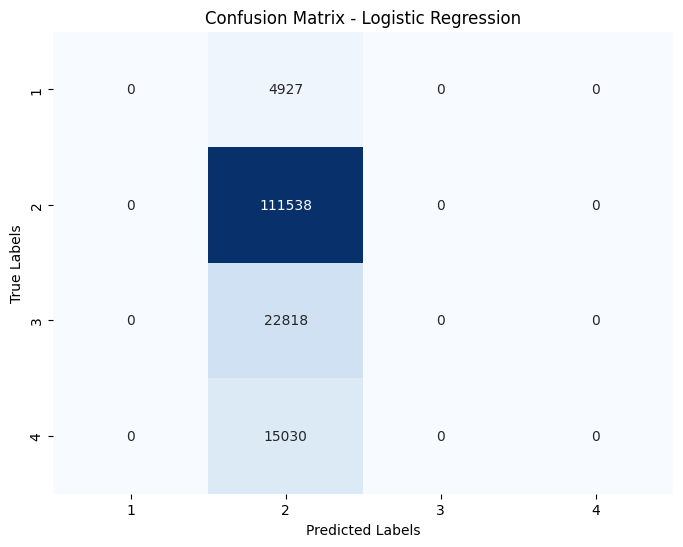

In [ ]:

# Convert predictions and labels to RDD
prediction_and_label = predictions_lr.select("prediction", "Severity").rdd.map(lambda x: (float(x[0]), float(x[1])))

# Instantiate MulticlassMetrics
metrics_lr = MulticlassMetrics(prediction_and_label)

# Get confusion matrix
confusion_mat_lr = metrics_lr.confusionMatrix().toArray()

# Convert the confusion matrix to Pandas DataFrame for visualization
import pandas as pd
confusion_df_lr = pd.DataFrame(confusion_mat_lr, index=range(1, len(confusion_mat_lr)+1), columns=range(1, len(confusion_mat_lr)+1))

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df_lr, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


Checking Class Distribution for getting 0 values for classes 1,2 and 4

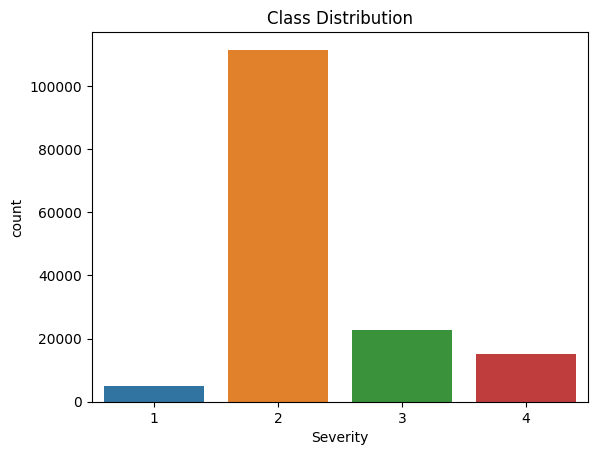

        Severity  prediction  \
0              1         2.0   
1              1         2.0   
2              1         2.0   
3              1         2.0   
4              1         2.0   
...          ...         ...   
154308         4         2.0   
154309         4         2.0   
154310         4         2.0   
154311         4         2.0   
154312         4         2.0   

                                              probability  
0       [0.0, 0.035785516629248684, 0.5917663029290451...  
1       [0.0, 0.035785516629248684, 0.5917663029290451...  
2       [0.0, 0.035785516629248684, 0.5917663029290451...  
3       [0.0, 0.035785516629248684, 0.5917663029290451...  
4       [0.0, 0.035785516629248684, 0.5917663029290451...  
...                                                   ...  
154308  [0.0, 0.0001703964557537203, 0.864705214131546...  
154309  [0.0, 0.035785516629248684, 0.5917663029290451...  
154310  [0.0, 0.035785516629248684, 0.5917663029290451...  
154311  [0.0, 0

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'predictions_pd' contains 'Severity', 'prediction', and 'probability' columns
predictions_pd = predictions.select("Severity", "prediction", "probability").toPandas()

# Visualize class distribution
sns.countplot(x='Severity', data=predictions_pd)
plt.title('Class Distribution')
plt.show()

# Check instances for classes 1, 2, and 4
class_instances = predictions_pd[predictions_pd['Severity'].isin([1, 2, 4])]
print(class_instances)


Converting Boolean values to Numerical values

In [ ]:
from pyspark.sql.functions import when

# Specify the columns to be updated
columns_to_update = ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
                      'Railway', 'Roundabout', 'Station', 'Stop']

# Map 'FALSE' to 0 and 'TRUE' to 1 for the specified columns
for col in columns_to_update:
    data = data.withColumn(col, when(data[col] == 'TRUE', 1).otherwise(0))


In [ ]:
data.show(10)

+--------+---------+----------+------------+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+
|Severity|Start_Lat| Start_Lng|Distance(mi)|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Speed(mph)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|
+--------+---------+----------+------------+--------------+-----------+------------+--------------+---------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+
|       3| 39.84495|-104.98484|         0.0|          73.0|         29|       24.37|          10.0|            8.0|      0|   0|       0|       0|       0|      0|      0|         0|      0|   0|
|       3| 39.84495|-104.98484|       0.015|          73.0|         29|       24.37|          10.0|            8.0|      0|   0|       0|       0|       0|      0|      0|         0|      0|   0|
|       2| 42.67713|

**GBT Classifier Model**

In [ ]:

feature_columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Wind_Speed(mph)"]
target_column = "Severity"

# Convert to binary classification label (1 if Severity is 2, 0 otherwise)
binary_data = data.withColumn("binary_label", (data[target_column] == 2).cast("double"))

# Vector Assembler to assemble features into a single column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="my_features")

# GBT classifier for binary classification
gbt_classifier = GBTClassifier(featuresCol="my_features", labelCol="binary_label", maxDepth=5, maxIter=20)

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, gbt_classifier])

# Split data into training and testing sets
train_data, test_data = binary_data.randomSplit([0.8, 0.2], seed=42)

# Train the model
model_gbt = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model_gbt.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"Area Under ROC (AUC): {auc}")

# Print the confusion matrix
confusion_matrix = predictions.select("binary_label", "prediction").groupBy("binary_label", "prediction").count()
confusion_matrix.show()


Area Under ROC (AUC): 0.6575679884290164
+------------+----------+------+
|binary_label|prediction| count|
+------------+----------+------+
|         1.0|       1.0|110400|
|         0.0|       1.0| 41271|
|         1.0|       0.0|  1138|
|         0.0|       0.0|  1504|
+------------+----------+------+



Area Under ROC (AUC): 0.6575705785362703


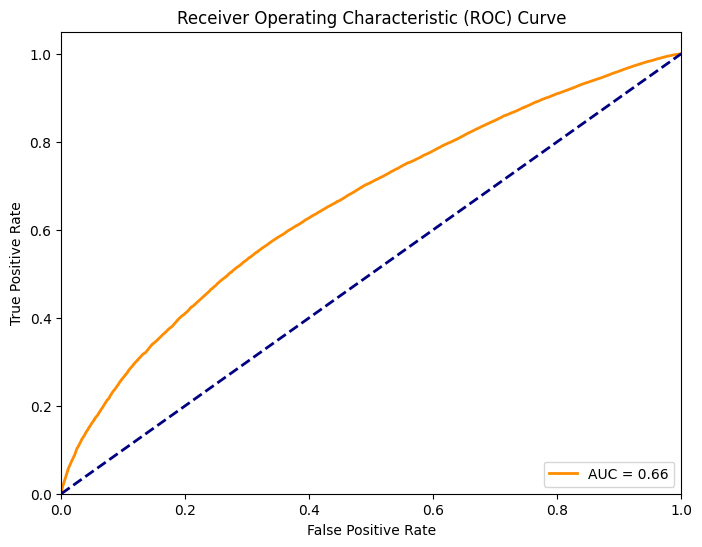

In [ ]:

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="binary_label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc_value = evaluator.evaluate(predictions)

print(f"Area Under ROC (AUC): {auc_value}")

# Convert to Pandas DataFrame
predictions_pd = predictions.toPandas()

# Get the fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(predictions_pd['binary_label'], predictions_pd['probability'].apply(lambda x: x[1]))

# Compute AUC using scikit-learn's auc function
roc_auc = sklearn_auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


**GBT Classifier Model** with Cross Validation technique for increasing the accuracy.

In [ ]:

# Let's create a new binary label column 'label'
train_data_binary = train_data.withColumn("label", when(train_data["Severity"] == 4, 1).otherwise(0))
test_data_binary = test_data.withColumn("label", when(test_data["Severity"] == 4, 1).otherwise(0))

# Feature columns for training
feature_columns = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Wind_Speed(mph)"]

# Vector Assembler to assemble features into a single column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# GBTClassifier
gbt = GBTClassifier(featuresCol="features", labelCol="label", maxIter=10)

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, gbt])

# Create ParamGrid for Cross Validation
param_grid = ParamGridBuilder().build()

# Multiclass Classification evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")

# CrossValidator
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Run cross-validation, and choose the best set of parameters
cv_model = crossval.fit(train_data_binary)

# Make predictions on the test set
predictions = cv_model.transform(test_data_binary)

# Evaluate the model
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Extract labels and predictions as NumPy arrays
true_labels = predictions.select("label").rdd.flatMap(lambda x: x).collect()
predicted_labels = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

Accuracy: 0.9003781399117674
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.90      1.00      0.95     20000
     Class 1       1.00      0.00      0.00      2214

    accuracy                           0.90     22214
   macro avg       0.95      0.50      0.47     22214
weighted avg       0.91      0.90      0.85     22214



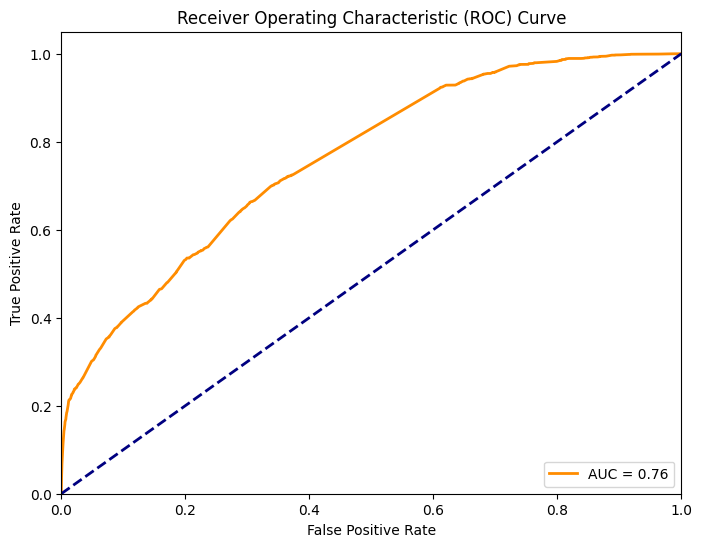

In [ ]:

# Assuming 'prediction' column contains rawPrediction
predictions = cv_model.transform(test_data_binary).select(col("label").cast("double"), col("probability"))

# Convert to Pandas DataFrame
predictions_pd = predictions.toPandas()

# Get the fpr, tpr, and thresholds
fpr, tpr, thresholds = roc_curve(predictions_pd['label'], predictions_pd['probability'].apply(lambda x: x[1]))

# Compute AUC
auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_value:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
